In [1]:
import os
import json
import open3d as o3d
from open3d.web_visualizer import draw
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../point-e')
from point_e.util.point_cloud import PointCloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
f = open('../shapeglot_text2shape/attnglot_results_pointe_towardsimpl.json')
pointe_towardsimpl_data = json.load(f)
print(len(pointe_towardsimpl_data))

f = open('human_test_set_final.json')
hts_data = json.load(f)
print(len(hts_data))
print(hts_data)


1749
2153
[{'gt_id': 'ed0d65c68a1fa5c485e2f8b1d3a373fe', 'dist_id': '24d3d4259b35fb93490ad276cd2af3a4', 'text': '1 chair with red color cover on it from head rest to foot without hand rest', 'dataset': 't2s', 'task': 'hard', 'tensor_name': 'text_68287.pt'}, {'gt_id': 'ed0d65c68a1fa5c485e2f8b1d3a373fe', 'dist_id': '73aeafc0af4f1a62e1c624539dfec6c4', 'text': '1 chair with red color cover on it from head rest to foot without hand rest', 'dataset': 't2s', 'task': 'easy', 'tensor_name': 'text_68287.pt'}, {'gt_id': '215e557db4c4bb5d837b757304479228', 'dist_id': '1007e20d5e811b308351982a6e40cf41', 'text': 'a rocking chair, brown frame, earth colored cushions', 'dataset': 't2s', 'task': 'hard', 'tensor_name': 'text_41858.pt'}, {'gt_id': '1007e20d5e811b308351982a6e40cf41', 'dist_id': '23b52ffd037c95223704253c4a874401', 'text': 'A beige wooden rocking chair with a curved back and slotted dowel backrest, featuring 8 poles and rocking feet.', 'dataset': 'gpt2s', 'task': 'hard', 'tensor_name': 'tex

In [3]:
def get_data_paths(pointe_filename, towardsimpl_filename, save_figs=False, plot_figs=False):
        
        # process filename
        towardsimpl_basename = os.path.splitext(os.path.basename(towardsimpl_filename))[0]
        
        towardsimpl_base_nospaces = towardsimpl_basename.replace(" ", "")
        towardsimpl_base_nospaces = towardsimpl_base_nospaces.replace("[CLS]", "")
        towardsimpl_base_nospaces = towardsimpl_base_nospaces.replace("##", "")

        if plot_figs or save_figs:
            towardsimpl_cloud = o3d.io.read_point_cloud(towardsimpl_filename)
            R = towardsimpl_cloud.get_rotation_matrix_from_xyz((0, -np.pi / 2, 0))
            towardsimpl_cloud.rotate(R, center=(0, 0, 0))
            points = np.asarray(towardsimpl_cloud.points)
            colors = np.asarray(towardsimpl_cloud.colors)
            x = points[:,0]
            y = points[:,1]
            z = points[:,2]
            c = colors
            fig = plt.figure()
            plt.title(towardsimpl_basename)
            ax = fig.add_subplot(projection='3d')
            ax.scatter(x, y, z, c=colors)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_zticklabels([])

            # if the cloud is white, we set a black background
            if np.mean(c) > 0.9:
                ax.set_facecolor('dimgray')
            
            if plot_figs:
                plt.show()

            if save_figs:
                extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join('towardsimpl', towardsimpl_base_nospaces + '.png'), bbox_inches=extent)
            
            plt.close()
                 

        # process filename
        point_e_basename = os.path.splitext(os.path.basename(pointe_filename))[0]
        point_e_base_nospaces = point_e_basename.replace(" ", "")

        if plot_figs or save_figs:
            point_e_cloud = PointCloud.load(pointe_filename)
            point_e_cloud = point_e_cloud.farthest_point_sample(2048)
            points = point_e_cloud.coords
            colors = np.stack([point_e_cloud.channels["R"], point_e_cloud.channels["G"], point_e_cloud.channels["B"]], axis=1)
            x = points[:,0]
            y = points[:,1]
            z = points[:,2]
            c = colors

            fig = plt.figure()
            plt.title(point_e_basename)
            ax = fig.add_subplot(projection='3d')
            ax.scatter(x, y, z, c=colors)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_zticklabels([])
        
            # if the cloud is white, we set a black background
            if np.mean(c) > 0.9:
                ax.set_facecolor('dimgray')

            if plot_figs:
                plt.show()
            if save_figs:
                extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join('point_e', point_e_base_nospaces + '.png'), bbox_inches=extent)

            plt.close()

        towardsimpl_figname = towardsimpl_base_nospaces
        point_e_figname = point_e_base_nospaces
        return point_e_figname, towardsimpl_figname


  0%|          | 0/2153 [00:00<?, ?it/s]

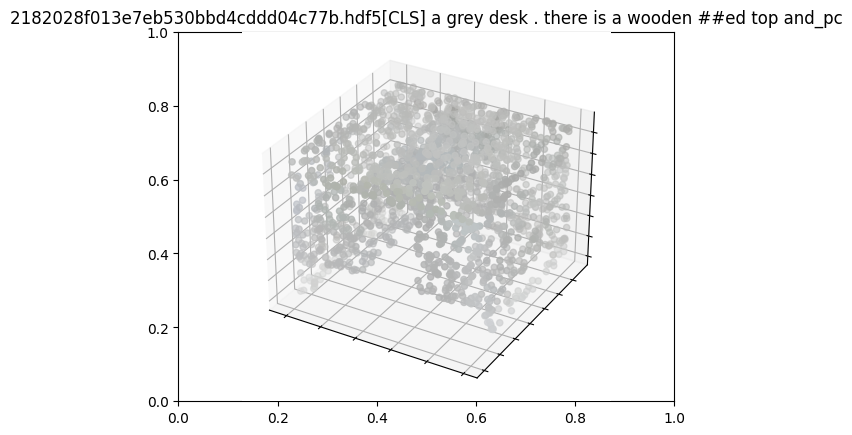

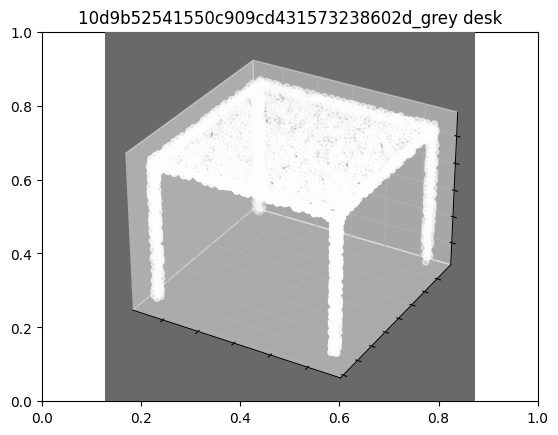

  0%|          | 0/2153 [00:00<?, ?it/s]


In [8]:
### NEW CODE ###

# iterate over data samples

output_json = []
out_file = open("humaneval_genshapes_test.json", "w")

count_miss=0
for d in tqdm(hts_data):
    found=False
    
    gt_id = d["gt_id"]
    text = d["text"]

    gt_id = '10d9b52541550c909cd431573238602d'
    text = 'grey desk'

    # Point-E shapes have filename with <gt_id>_text[:10] where gt_id is the mid chosen by the users
    if text == "grey rectangular table with straight legs connected in pairs":
        search = gt_id + '_A grey rectangular t'
    else:
        search = gt_id + f'_{text[:10]}'
        
    search = search.replace('/', '_')

    for idx, p_t_data in enumerate(pointe_towardsimpl_data):
        if search in p_t_data["point_e_file"]:
            found=True
            point_e_file = p_t_data["point_e_file"]
            towardsimpl_file = p_t_data["towardsimpl_file"]
            break
    
    if not found:
        print('data sample not found: ', search)
    
    pointe_figname, towardsimpl_figname = get_data_paths(point_e_file, towardsimpl_file, save_figs=True, plot_figs=True)

    output_json.append({"towardsimpl":  towardsimpl_figname,
                        "point_e":      pointe_figname,
                        "text":         text})

    break
#json.dump(output_json, out_file, indent=4)

out_file.close()

In [17]:
print(len(output_json))

2153


In [ ]:
### OLD CODE ###
# iterate over data samples

output_json = []
out_file = open("humaneval_genshapes_test.json", "w")

count_miss=0
for d in tqdm(data):

    towardsimpl_file = d["towardsimpl_file"]
    point_e_file = d["point_e_file"]

    towardsimpl_base = os.path.splitext(os.path.basename(towardsimpl_file))[0]
    point_e_base = os.path.splitext(os.path.basename(point_e_file))[0]

    model_id = point_e_base[:32]

    for gt_d in gt_data:
        if model_id=='1a74a83fa6d24b3cacd67ce2c72c02e':
            if model_id in gt_d["gt_id"]:
                text=gt_d["text"]
                print('found text: ', text)
                break
    
    # get figures
    if not os.path.exists(towardsimpl_file):
        count_miss+=1
        print('miss towardsimpl: ', towardsimpl_file)
    else:
        towardsimpl_cloud = o3d.io.read_point_cloud(towardsimpl_file)
        R = towardsimpl_cloud.get_rotation_matrix_from_xyz((0, -np.pi / 2, 0))
        towardsimpl_cloud.rotate(R, center=(0, 0, 0))
        points = np.asarray(towardsimpl_cloud.points)
        colors = np.asarray(towardsimpl_cloud.colors)
        x = points[:,0]
        y = points[:,1]
        z = points[:,2]
        c = colors
        
        fig = plt.figure()
        #plt.title(towardsimpl_base)
        ax = fig.add_subplot(projection='3d')
        ax.scatter(x, y, z, c=colors)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])

        # if the cloud is white, we set a black background
        if np.mean(c) > 0.9:
            ax.set_facecolor('dimgray')

        #plt.show()
        towardsimpl_base_nospaces = towardsimpl_base.replace(" ", "")
        towardsimpl_base_nospaces = towardsimpl_base_nospaces.replace("[CLS]", "")
        towardsimpl_base_nospaces = towardsimpl_base_nospaces.replace("##", "")

        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(os.path.join('towardsimpl', towardsimpl_base_nospaces + '.png'), bbox_inches=extent)
        plt.close()


        point_e_cloud = PointCloud.load(point_e_file)
        point_e_cloud = point_e_cloud.farthest_point_sample(2048)
        points = point_e_cloud.coords
        colors = np.stack([point_e_cloud.channels["R"], point_e_cloud.channels["G"], point_e_cloud.channels["B"]], axis=1)

        x = points[:,0]
        y = points[:,1]
        z = points[:,2]
        c = colors

        fig = plt.figure()
        plt.title(point_e_base)
        ax = fig.add_subplot(projection='3d')
        ax.scatter(x, y, z, c=colors)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        
        # if the cloud is white, we set a black background
        if np.mean(c) > 0.9:
            ax.set_facecolor('dimgray')

        #plt.show()
        point_e_base_nospaces = point_e_base.replace(" ", "")
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #fig.savefig(os.path.join('point_e', point_e_base_nospaces + '.png'), bbox_inches=extent)
        plt.close()

        output_json.append({'towardsimpl': towardsimpl_base_nospaces,
                            'point_e': point_e_base_nospaces,
                            'text': text})


json.dump(output_json, out_file, indent=4)

print('count_miss: ', count_miss)

out_file.close()